In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)

#---------------------------------------------------------------------------#
#User imports
import sys
sys.path.append('/Users/fardila/Documents/GitHub/HSC_vs_hydro/')
from functions import *

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


      +------------------------------------------------------------+
      |             Space Telescope Tables Package                 |
      |                  TABLES Version 3.18.3                     |
      |                                                            |
      |   Space Telescope Science Institute, Baltimore, Maryland   |
      |   Copyright (C) 2014 Association of Universities for       |
      |            Research in Astronomy, Inc.(AURA)               |
      |       See stsdas$copyright.stsdas for terms of use.        |
      |         For help, send e-mail to help@stsci.edu            |
      +------------------------------------------------------------+
tables/:
 fitsio/        tbplot/         tobsolete/      ttools/


      +------------------------------------------------------------+
      |       Space Telescope Science Data Analysis System         |
  

In [2]:
tng_highres_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2_highres.hdf5'
tng_quick_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2.hdf5'
pixel_scale_highres, pixel_scale_quick = get_pixel_scale(tng_highres_file), get_pixel_scale(tng_quick_file)
print pixel_scale_highres, pixel_scale_quick

1.0 5.333333333333333


In [3]:
illustris_quick_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_stellarmaps_orig_11.2.hdf5'
pixel_scale_quick = get_pixel_scale(illustris_quick_file)
print pixel_scale_quick

5.333333333333333


In [4]:
def reduce_map(map, pixel_scale, final_size_in_kpc):
    current_size_in_pixels = len(map)
    final_size_in_pixels = float(final_size_in_kpc) / pixel_scale
    
    diff = int((current_size_in_pixels - final_size_in_pixels)/2.)
    
    if diff==0:
        return map
    else:
        return map[diff:-diff,diff:-diff]

In [5]:
def galaxy_image(sim_file, sim_name, pixel_scale, ax, gal_n=0):
    #central pixels
    x0=150.
    y0=150.

    # Load maps
    mass_map_cen, mass_map_cen_icl, pixel_scale, m_cat = get_mass_maps(sim_file, gal_n=gal_n)

    #postage mass
    m_post = np.log10(np.sum(mass_map_cen))
    m_post_icl = np.log10(np.sum(mass_map_cen_icl))


    #ouput maps
    maps_location='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/fits_files/quick_800/'

    file_name=sim_name+'_'+str(gal_n)+'_xy'
    fits_prefix = maps_location + file_name
#     save_to_fits(mass_map_cen, fits_prefix + '_cen.fits')
    # save_to_fits(img_cen_sat, fits_prefix + '_cen_sat.fits')
    # save_to_fits(img_cen_icl, fits_prefix + '_cen_icl.fits')
    # save_to_fits(img_all, fits_prefix + '_all.fits')

    
    suffix='_cen'

    ###########################################################################
    #reduce map size to make them comparable
    data = np.ascontiguousarray(reduce_map(mass_map_cen, pixel_scale, 300))
#     data = mass_map_cen
    x0=len(data)/2.
    y0=x0
    
    #get background
    bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
    bkg_subtraced_data = data - bkg

    thresh = 50 * bkg.globalrms
    objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                          deblend_nthresh=24, deblend_cont=0.1)

    #find object closest to image center
    obj = find_closest(objects, x0=x0, y0=y0)

    #ellipse parameters
    theta = obj['theta']
    q = obj['b']/ obj['a']
    print 'q: ', q, ', theta: ', theta
    print 'ell: ', 1-q, ', pa: ', theta* 180. / np.pi
    

    
    # plot background-subtracted image
    m, s = np.mean(data), np.std(data)
#     fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(data, interpolation='nearest', cmap=plt.get_cmap('viridis'),
                   vmin=m/100., vmax=m+s, origin='lower')

    
    #add ellipses
    for r in [10.,25.,50.,75., 100.,125.]:
        a=r/pixel_scale
        b=a*q
        e = Ellipse(xy=(obj['x'], obj['y']),
                 width=a*2,
                 height=b*2,
                 angle=theta * 180. / np.pi,
                  lw=4)
        e.set_facecolor('none')
        e.set_edgecolor('red')
        ax.add_artist(e)

    #scale bar
    img_size = len(data)
    scale_bar_length = 50 #kpc
    scale_bar_y = (img_size * 0.15)
    scale_bar_x_0 = (img_size * 0.9 - (scale_bar_length / pixel_scale))
    scale_bar_x_1 = (img_size * 0.9)
    ax.plot([scale_bar_x_0, scale_bar_x_1], [scale_bar_y, scale_bar_y], linewidth=3,
            c='w', alpha=1.0)
    #text
    scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
    scale_bar_text_y = (scale_bar_y - img_size*0.07)
    scale_bar_text = r'$%d\ \mathrm{kpc}$' % int(scale_bar_length)
    ax.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, fontsize=40, weight='bold',
            horizontalalignment='center', color='w')
    
    plt.xticks([])
    plt.yticks([])
    
    #color bar
#     ax_cbar = inset_axes(ax1, width=color_bar_width, height=color_bar_height, loc=color_bar_loc)
#     cbar = plt.colorbar(show, ax=ax, cax=ax_cbar, orientation='horizontal')
#     cbar = plt.colorbar(im, ax=ax)

#         cbar.ax.xaxis.set_tick_params(color=color_bar_color)
#         cbar.ax.yaxis.set_tick_params(color=color_bar_color)
#         cbar.outline.set_edgecolor(color_bar_color)
#         plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'),
#                  color=color_bar_color, fontsize=color_bar_fontsize)
#         plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'),
#                  color=color_bar_color, fontsize=color_bar_fontsize)

#     plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Figures/ellipses/quick_800/'+file_name)
#     plt.clf()


#     plt.show()


q:  0.6364325611233148 , theta:  -1.526005744934082
ell:  0.3635674388766852 , pa:  -87.4336886974401


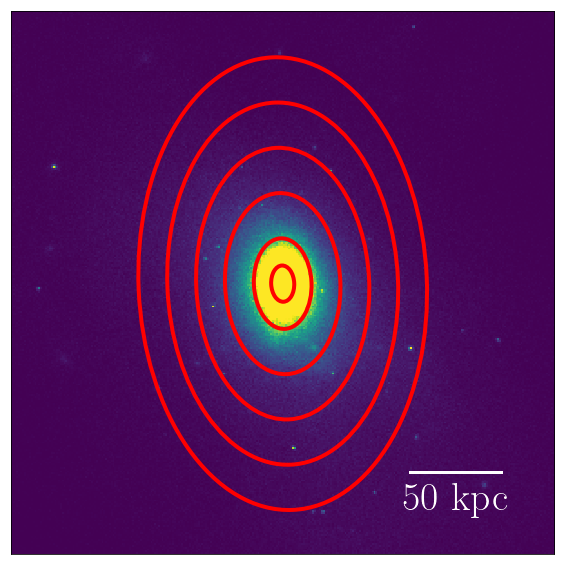

In [19]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
galaxy_image(tng_highres_file, 'TNG_highres', pixel_scale_highres, ax, gal_n=0)
#galaxy_image(tng_quick_file, 'TNG_quick', pixel_scale_quick, ax[1], gal_n=0)

plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/talks/figures/TNG_highres_mass_map.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

q:  0.7697322360837 , theta:  -1.0003126859664917
ell:  0.2302677639163 , pa:  -57.313695099275265


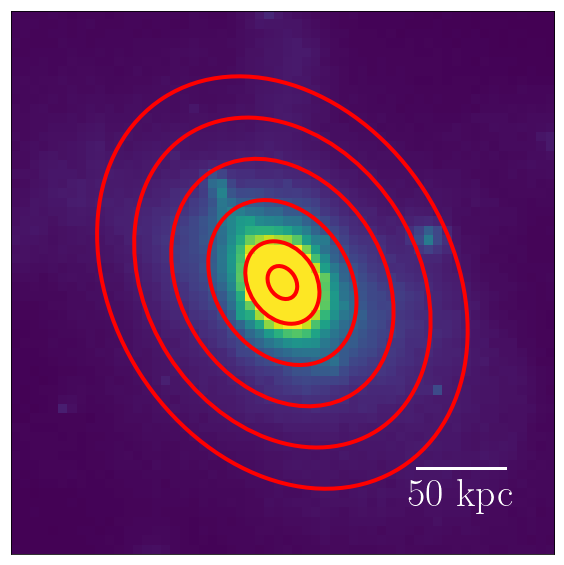

In [20]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
galaxy_image(illustris_quick_file, 'Illustris_quick', pixel_scale_quick, ax, gal_n=0)
#galaxy_image(tng_quick_file, 'TNG_quick', pixel_scale_quick, ax[1], gal_n=0)

plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/talks/figures/Illustris_quick_mass_map.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

# HSC 

In [6]:
from astropy.cosmology import WMAP9
from astropy.io import fits
import img_scale

### determine pixel scale

In [7]:
HSC_pixel_scale = 0.17 #arcsec/pixel

projected_scale = WMAP9.kpc_proper_per_arcmin(0.25).value / 60. #kpc/arcsec

pixel_scale = HSC_pixel_scale * projected_scale #kpc/pixel

print pixel_scale


0.672887059362


In [8]:
files_loc = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/images/'

g_file = files_loc + 'cutout-HSC-G-9347-s18a_wide-180627-010558.fits'
r_file = files_loc + 'cutout-HSC-R-9347-s18a_wide-180627-010607.fits'
i_file = files_loc + 'cutout-HSC-I-9347-s18a_wide-180627-010424.fits'

In [9]:
hdu_g = fits.open(g_file)
hdu_r = fits.open(r_file)
hdu_i = fits.open(i_file)

g_data=hdu_g[1].data
r_data=hdu_r[1].data
i_data=hdu_i[1].data

In [10]:
data=g_data
data.shape

(715, 715)

In [16]:
data = g_data.byteswap().newbyteorder()

q:  0.8764981582435343 , theta:  1.420768141746521
ell:  0.12350184175646572 , pa:  81.40401818872036
img_scale : sqrt
img_scale : sqrt
img_scale : sqrt


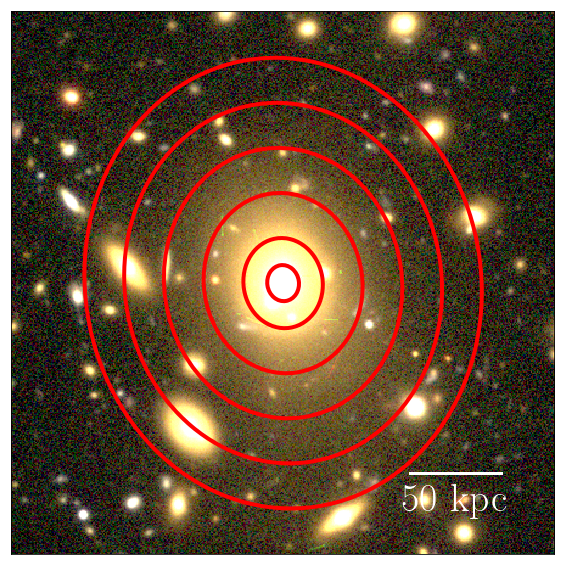

In [17]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))

x0=len(data)/2.
y0=x0


#get background
bkg = sep.Background(data, bw=10, bh=10, fw=5, fh=5)
bkg_subtraced_data = data - bkg

thresh = 50 * bkg.globalrms
objects = sep.extract(bkg_subtraced_data, thresh, minarea = 100,
                      deblend_nthresh=24, deblend_cont=0.1)

#find object closest to image center
obj = find_closest(objects, x0=x0, y0=y0)

#ellipse parameters
theta = obj['theta']
q = obj['b']/ obj['a']
print 'q: ', q, ', theta: ', theta
print 'ell: ', 1-q, ', pa: ', theta* 180. / np.pi



# plot background-subtracted image
# m, s = np.median(data), np.std(data)
# #     fig, ax = plt.subplots(figsize=(10, 10))
# im = ax.imshow(data, interpolation='nearest', cmap=plt.get_cmap('viridis'),
#                vmin=m/100., vmax=m+s, origin='lower')

#reduce map size to make them comparable
i_data = np.ascontiguousarray(reduce_map(i_data, pixel_scale, 300))
r_data = np.ascontiguousarray(reduce_map(r_data, pixel_scale, 300))
g_data = np.ascontiguousarray(reduce_map(g_data, pixel_scale, 300))

x0=len(i_data)/2.
y0=x0

img = np.zeros((i_data.shape[0], i_data.shape[1], 3), dtype=float)
img[:,:,0] = img_scale.sqrt(i_data, scale_min=0, scale_max=1)
img[:,:,1] = img_scale.sqrt(r_data, scale_min=0, scale_max=1)
img[:,:,2] = img_scale.sqrt(g_data, scale_min=0, scale_max=1)

plt.imshow(img, aspect='equal')

#add ellipses
for r in [10.,25.,50.,75., 100.,125.]:
    a=r/pixel_scale
    b=a*q
    e = Ellipse(xy=(x0, y0),
             width=a*2,
             height=b*2,
             angle=theta * 180. / np.pi,
              lw=4)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

#scale bar
img_size = len(i_data)
scale_bar_length = 50 #kpc
scale_bar_y = (img_size * 0.85)
scale_bar_x_0 = (img_size * 0.9 - (scale_bar_length / pixel_scale))
scale_bar_x_1 = (img_size * 0.9)
ax.plot([scale_bar_x_0, scale_bar_x_1], [scale_bar_y, scale_bar_y], linewidth=3,
        c='w', alpha=1.0)
#text
scale_bar_text_x = (scale_bar_x_0 + scale_bar_x_1) / 2
scale_bar_text_y = (scale_bar_y + img_size*0.07)
scale_bar_text = r'$%d\ \mathrm{kpc}$' % int(scale_bar_length)
ax.text(scale_bar_text_x, scale_bar_text_y, scale_bar_text, fontsize=40, weight='bold', 
        horizontalalignment='center', color='w')


plt.xticks([])
plt.yticks([])

plt.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/talks/figures/HSC_rgb_map.pdf',
            dpi=100, format='pdf', bbox_inches='tight')

## rgb image 

In [14]:
img = np.zeros((i_data.shape[0], i_data.shape[1], 3), dtype=float)
img[:,:,0] = img_scale.sqrt(i_data, scale_min=0, scale_max=1)
img[:,:,1] = img_scale.sqrt(r_data, scale_min=0, scale_max=1)
img[:,:,2] = img_scale.sqrt(g_data, scale_min=0, scale_max=1)

img_scale : sqrt
img_scale : sqrt
img_scale : sqrt


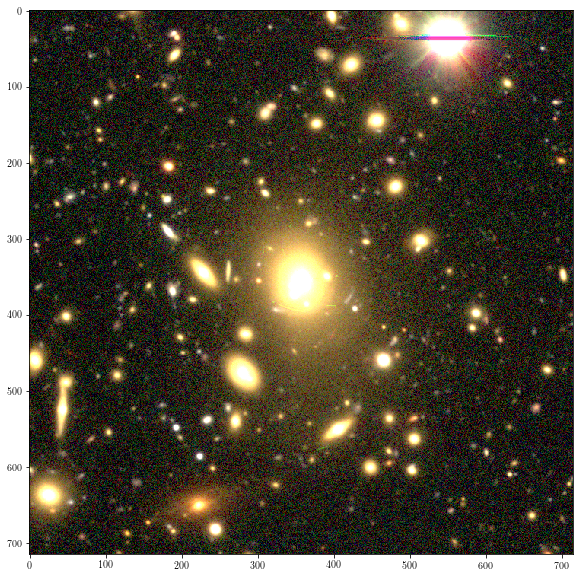

In [16]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
plt.imshow(img, aspect='equal')
#py.savefig('my_rgb_image.png')